In [2]:
import shap
shap.initjs() #helps with the ability to display images in notebook
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_csv('final_data.csv')
df.columns

Index(['race_eth_name', 'geotype', 'geoname', 'county_name', 'region_code',
       'cost_yr', 'median_income', 'affordability_ratio',
       'LL95_affordability_ratio', 'UL95_affordability_ratio',
       'rse_food_afford', 'CA_RR_Affordability', 'ave_fam_size', 'latitude',
       'longitude', 'affordability_per_person', 'food_cost_index',
       'affordable'],
      dtype='object')

In [14]:
df = pd.read_csv('final_data.csv')
df['affordability_ratio'] = df['affordability_ratio'].fillna(df['affordability_ratio'].mean()) # make sure response has no NAs

# get my X and Y matrices
X = df.drop(columns = ['affordability_ratio','LL95_affordability_ratio', 'UL95_affordability_ratio',
       'rse_food_afford', 'CA_RR_Affordability', 'affordability_per_person', 'affordable'])
features = X.columns
y = df['affordability_ratio']
# extract only the column names for each type
numeric_features = X.select_dtypes(include = ['number']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307) # split the data

# make transformers for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                  
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('filtering', SelectPercentile(f_regression, percentile=50))     
])

# run both through the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      
        ('cat', categorical_transformer, categorical_features)  
    ])

In [15]:
# need to deal with categorical
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Access the OneHotEncoder and SelectPercentile steps
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
selector = preprocessor.named_transformers_['cat'].named_steps['filtering']

# Get all one-hot encoded feature names
onehot_feature_names = onehot.get_feature_names_out(categorical_features)

# Apply the SelectPercentile mask
mask = selector.get_support()  # Boolean mask of selected features
selected_categorical_features = onehot_feature_names[mask]

final_feature_names = list(numeric_features) + list(selected_categorical_features)
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}
gb_grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose = 1
)
gb_grid_search.fit(X_train_processed, y_train)
print(f"Best Parameters: {gb_grid_search.best_params_}")
# Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-gb_grid_search.best_score_}")
# Best MSE: 132159.55162585393
y_test_pred = gb_grid_search.predict(X_test_processed)
mse = root_mean_squared_error(y_test, y_test_pred)
print(f'Test rMSE: {mse}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best MSE: 0.00013304951024929618
Test rMSE: 0.015282375155150112


In [16]:
model = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0,
    random_state=42  
)

model.fit(X_train_processed, y_train)
y_pred_model = model.predict(X_test_processed)

mse = root_mean_squared_error(y_test, y_pred_model)
print(f'Test rMSE: {mse}')

Test rMSE: 0.015282375155150112


# SHAP

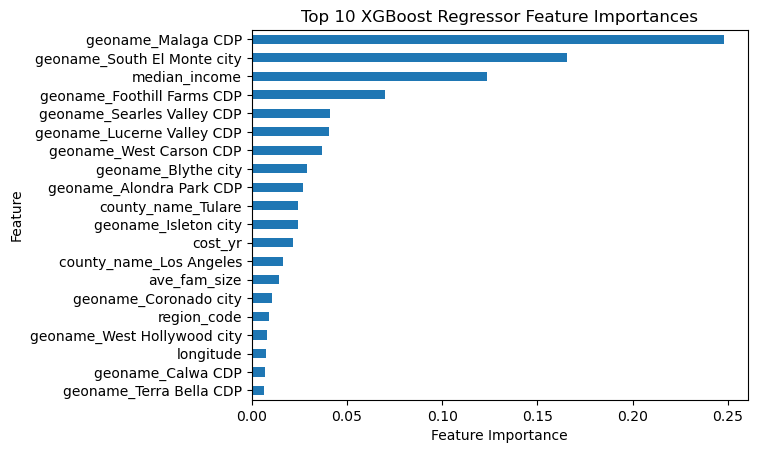

In [17]:
# Create a Series for feature importances
feature_importances = pd.Series(model.feature_importances_, index=final_feature_names)

# Select the top 10 features
top_10_features = feature_importances.nlargest(20)

# Plot the top 10 feature importances
top_10_features.plot.barh()
plt.title('Top 10 XGBoost Regressor Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()